# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах).

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('lenta_40k.csv.zip')
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

len(vocab)

354611

In [7]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

len(filtered_vocab)

24091

In [8]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [9]:
id2word = {i:word for word, i in word2id.items()}

In [10]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [11]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(44356, 200)

In [12]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])
len(label2id)

19

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

### 1 модель - обычные слои

In [14]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = keras.layers.LSTM(64, return_sequences=True)(embeddings)
lstm2 = keras.layers.LSTM(64, return_sequences=True)(lstm1)

avg_pool = keras.layers.GlobalAveragePooling1D()(lstm2)
max_pool = keras.layers.GlobalMaxPooling1D()(lstm2)

concatenated = keras.layers.concatenate([lstm2[:, -1, :], avg_pool, max_pool])

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concatenated)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 30)        │        722,790 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 200, 64)        │         24,320 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 200, 64)        │         33,024 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 64)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ lstm_1[0][0]           │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 64)             │              0 │ lstm_1[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ get_item[0][0],        │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 19)             │          3,667 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 783,801 (2.99 MB)

 Trainable params: 783,801 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 531ms/step - loss: 2.6917 - rec@prec: 1.8939e-06 - val_loss: 2.3197 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 517ms/step - loss: 2.3098 - rec@prec: 7.6065e-05 - val_loss: 2.0735 - val_rec@prec: 0.0054
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 503ms/step - loss: 1.9209 - rec@prec: 0.0216 - val_loss: 1.5394 - val_rec@prec: 0.2245
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 538ms/step - loss: 1.3877 - rec@prec: 0.3029 - val_loss: 1.2582 - val_rec@prec: 0.4292
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 507ms/step - loss: 1.0817 - rec@prec: 0.5509 - val_loss: 1.1836 - val_rec@prec: 0.5153
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - loss: 0.8913 - rec@prec: 0.6730 - val_loss: 1.0774 - val_rec@prec: 0.5933
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 495ms/step - loss: 0.7342 - rec@prec: 0.7759 - val_loss: 1.1215 - val_rec@prec: 0.5546
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step - loss: 0.6343 - rec@prec: 0.827

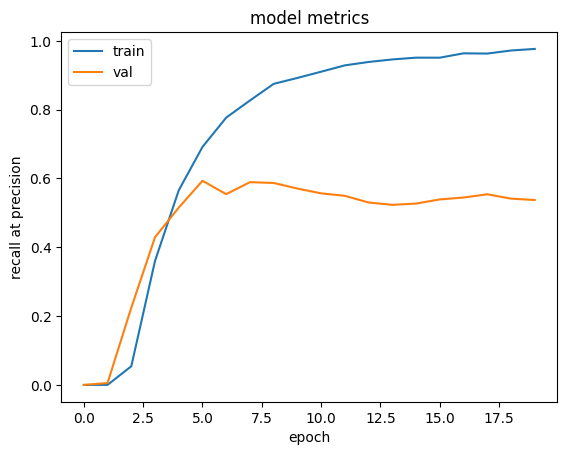

In [17]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
from sklearn.metrics import classification_report

In [33]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step


In [42]:
y_test = np.argmax(y_valid, axis=1)

In [36]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

   Интернет и СМИ       0.44      0.45      0.44       132
  Наука и техника       0.70      0.65      0.68       160
Силовые структуры       0.27      0.25      0.26        60
        Экономика       0.71      0.77      0.74       239
         Ценности       0.73      0.35      0.47        23
             Крым       0.00      0.00      0.00         2
              Мир       0.72      0.74      0.73       410
           Бизнес       0.21      0.14      0.17        22
      Путешествия       0.19      0.14      0.16        21
       Библиотека       0.00      0.00      0.00         0
   69-я параллель       0.00      0.00      0.00         4
    Культпросвет        0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         0
           Россия       0.68      0.67      0.68       481
      Бывший СССР       0.63      0.64      0.64       159
         Из жизни       0.22      0.25      0.24       

### 2 модель - bidirectional

In [37]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(embeddings)
lstm2 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(lstm1)

avg_pool = keras.layers.GlobalAveragePooling1D()(lstm2)
max_pool = keras.layers.GlobalMaxPooling1D()(lstm2)

concatenated = keras.layers.concatenate([lstm2[:, -1, :], avg_pool, max_pool])

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concatenated)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [38]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 200, 30)        │        722,790 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 200, 128)       │         48,640 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 200, 128)       │         98,816 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128)            │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ bidirectional_1[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 128)            │              0 │ bidirectional_1[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 384)            │              0 │ get_item_1[0][0],      │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 19)             │          7,315 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 877,561 (3.35 MB)

 Trainable params: 877,561 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 2.1031 - rec@prec: 3.4144e-04 - val_loss: 1.7899 - val_rec@prec: 0.0086
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 1.6378 - rec@prec: 0.0922 - val_loss: 1.3457 - val_rec@prec: 0.3490
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 1.1839 - rec@prec: 0.4695 - val_loss: 1.1723 - val_rec@prec: 0.4698
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.9033 - rec@prec: 0.6643 - val_loss: 1.0652 - val_rec@prec: 0.5645
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.7189 - rec@prec: 0.7813 - val_loss: 1.0710 - val_rec@prec: 0.5473
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.6037 - rec@prec: 0.8431 - val_loss: 1.1123 - val_rec@prec: 0.5361
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.5819 - rec@prec: 0.8483 - val_loss: 1.1175 - val_rec@prec: 0.5834
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.4453 - rec@prec: 0.9088 - val_loss: 1.1777 - val_rec@p

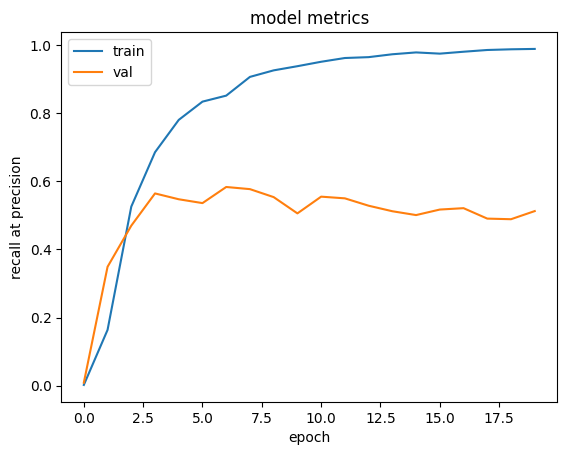

In [43]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 540ms/step


In [45]:
y_test = np.argmax(y_valid, axis=1)

In [47]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

   Интернет и СМИ       0.33      0.48      0.39       132
  Наука и техника       0.68      0.60      0.64       160
Силовые структуры       0.38      0.30      0.33        60
        Экономика       0.81      0.71      0.76       239
         Ценности       0.62      0.70      0.65        23
             Крым       0.00      0.00      0.00         2
              Мир       0.71      0.66      0.68       410
           Бизнес       0.20      0.18      0.19        22
      Путешествия       0.12      0.10      0.11        21
       Библиотека       0.00      0.00      0.00         0
   69-я параллель       0.00      0.00      0.00         4
    Культпросвет        0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         0
           Россия       0.71      0.70      0.71       481
      Бывший СССР       0.53      0.77      0.63       159
         Из жизни       0.36      0.29      0.32       

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:  
1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM
2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать
3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [55]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00


In [56]:
from datasets import load_dataset

In [57]:
dataset = load_dataset("tner/wikiann", 'ru')

README.md:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

wikiann.py:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


test.jsonl:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [63]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

len(vocab)

36015

In [59]:
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [60]:
id2word = {i:word for word, i in word2id.items()}

In [61]:
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [62]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [65]:
MAX_LEN = max(len(x) for x in X)

X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [66]:
label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2labels = {v:k for k,v in label2id.items()}

In [67]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [68]:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [69]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

### 1 модель - GRU + LSTM

In [100]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

gru = keras.layers.GRU(64, return_sequences=True)(embeddings)
lstm = keras.layers.LSTM(64, return_sequences=True)(gru)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model1 = keras.Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [101]:
model1.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 54)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_9 (Embedding)              │ (None, 54, 100)             │       3,601,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 54, 64)              │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 54, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 54, 8)               │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,667,116 (13.99 MB)

 Trainable params: 3,667,116 (13.99 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model1.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=20)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.8517 - loss: 0.6991 - val_accuracy: 0.9366 - val_loss: 0.2066
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.9404 - loss: 0.1860 - val_accuracy: 0.9474 - val_loss: 0.1430
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.9613 - loss: 0.1139 - val_accuracy: 0.9669 - val_loss: 0.0952
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.9800 - loss: 0.0590 - val_accuracy: 0.9703 - val_loss: 0.0899
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9888 - loss: 0.0376 - val_accuracy: 0.9711 - val_loss: 0.0928
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.9926 - loss: 0.0240 - val_accuracy: 0.9721 - val_loss: 0.0989
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.9957 - loss: 0.0163 - val_accuracy: 0.9724 - val_loss: 0.1015
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.9969 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


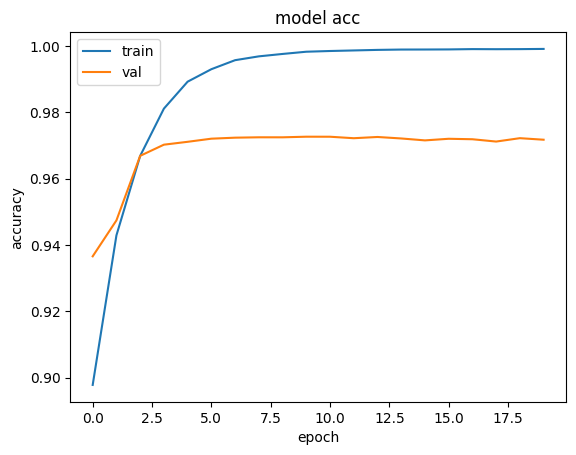

In [103]:
print(model1.history.history.keys())
plt.plot(model1.history.history['accuracy'])
plt.plot(model1.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [104]:
pred = model1.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step


In [105]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                   target_names=list(id2labels.values()),
                                                                   zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.51      0.69      0.59      4560
       B-ORG       0.41      0.69      0.51      4074
       B-PER       0.55      0.31      0.40      3542
       I-LOC       0.77      0.59      0.66      3060
       I-ORG       0.79      0.71      0.75      8008
       I-PER       0.91      0.52      0.66      7544
           O       0.88      0.93      0.91     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.73      0.68      0.69    540000
weighted avg       0.97      0.97      0.97    540000



### 2 модель - 3 рекуррентных слоя + residual connection

In [106]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

gru1 = keras.layers.GRU(100, return_sequences=True)(embeddings)

lstm = keras.layers.LSTM(100, return_sequences=True)(gru1)
concat1 = keras.layers.concatenate((lstm, embeddings))

gru2 = keras.layers.GRU(100, return_sequences=True)(concat1)
concat2 = keras.layers.concatenate((gru2, embeddings))

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat2)

model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [107]:
model2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 54)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 54, 100)        │      3,601,700 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_9 (GRU)               │ (None, 54, 100)        │         60,600 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_12 (LSTM)            │ (None, 54, 100)        │         80,400 │ gru_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 54, 200)        │              0 │ lstm_12[0][0],         │
│ (Concatenate)             │                        │                │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_10 (GRU)              │ (None, 54, 100)        │         90,600 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 54, 200)        │              0 │ gru_10[0][0],          │
│ (Concatenate)             │                        │                │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 54, 8)          │          1,608 │ concatenate_5[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,834,908 (14.63 MB)

 Trainable params: 3,834,908 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
model2.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=20)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 317ms/step - accuracy: 0.8645 - loss: 0.5860 - val_accuracy: 0.9537 - val_loss: 0.1521
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 318ms/step - accuracy: 0.9612 - loss: 0.1243 - val_accuracy: 0.9708 - val_loss: 0.0852
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 320ms/step - accuracy: 0.9817 - loss: 0.0576 - val_accuracy: 0.9749 - val_loss: 0.0713
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 324ms/step - accuracy: 0.9929 - loss: 0.0289 - val_accuracy: 0.9797 - val_loss: 0.0679
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 320ms/step - accuracy: 0.9968 - loss: 0.0145 - val_accuracy: 0.9758 - val_loss: 0.0736
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 322ms/step - accuracy: 0.9981 - loss: 0.0079 - val_accuracy: 0.9756 - val_loss: 0.0776
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 321ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9744 - val_loss: 0.0850
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 316ms/step - accuracy: 0.9988 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


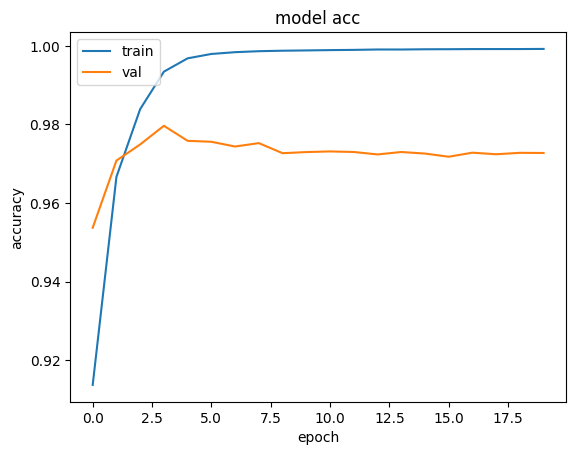

In [109]:
print(model2.history.history.keys())
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [110]:
pred = model2.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step


In [111]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                   target_names=list(id2labels.values()),
                                                                   zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.74      0.61      0.67      4560
       B-ORG       0.40      0.76      0.52      4074
       B-PER       0.54      0.48      0.51      3542
       I-LOC       0.82      0.56      0.66      3060
       I-ORG       0.71      0.79      0.75      8008
       I-PER       0.92      0.57      0.70      7544
           O       0.90      0.91      0.90     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.75      0.71      0.71    540000
weighted avg       0.98      0.97      0.97    540000



### 3 модель - rnn + cnn

In [112]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

conv1 = keras.layers.Conv1D(kernel_size=3, filters=64, activation='relu', padding='same')(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=3, filters=128, activation='relu', padding='same')(conv1)

gru = keras.layers.GRU(100, return_sequences=True)(conv2)
lstm = keras.layers.LSTM(100, return_sequences=True)(gru)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model3 = keras.Model(inputs=inputs, outputs=outputs)
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [113]:
model3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 54)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_11 (Embedding)             │ (None, 54, 100)             │       3,601,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 54, 64)              │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 54, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 54, 100)             │          69,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 54, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 54, 8)               │             808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,795,876 (14.48 MB)

 Trainable params: 3,795,876 (14.48 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
model3.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=20)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.8693 - loss: 0.5554 - val_accuracy: 0.9508 - val_loss: 0.1442
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.9617 - loss: 0.1123 - val_accuracy: 0.9782 - val_loss: 0.0709
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.9881 - loss: 0.0385 - val_accuracy: 0.9819 - val_loss: 0.0599
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.9955 - loss: 0.0170 - val_accuracy: 0.9813 - val_loss: 0.0639
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.9978 - loss: 0.0086 - val_accuracy: 0.9779 - val_loss: 0.0784
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.9987 - loss: 0.0056 - val_accuracy: 0.9789 - val_loss: 0.0797
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 214ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9795 - val_loss: 0.0838
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.9995 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


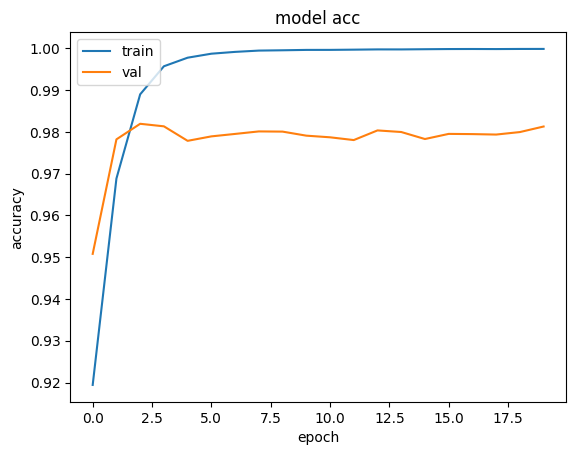

In [115]:
print(model3.history.history.keys())
plt.plot(model3.history.history['accuracy'])
plt.plot(model3.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [116]:
pred = model3.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step


In [117]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                   target_names=list(id2labels.values()),
                                                                   zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.59      0.78      0.67      4560
       B-ORG       0.72      0.68      0.70      4074
       B-PER       0.94      0.63      0.75      3542
       I-LOC       0.72      0.73      0.72      3060
       I-ORG       0.83      0.76      0.79      8008
       I-PER       0.96      0.73      0.83      7544
           O       0.90      0.96      0.93     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.83      0.78      0.80    540000
weighted avg       0.98      0.98      0.98    540000



### Инференс

In [118]:
import re

def tokenize(text, word2id):
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                    maxlen=max_len,
                                                                    padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [119]:
print('model1:', label_seq('На конференции Яндекса выступили представители компании Сбербанк и Мария Буркина', word2id, id2labels, MAX_LEN, model1))
print('model2:', label_seq('На конференции Яндекса выступили представители компании Сбербанк и Мария Буркина', word2id, id2labels, MAX_LEN, model2))
print('model3:', label_seq('На конференции Яндекса выступили представители компании Сбербанк и Мария Буркина', word2id, id2labels, MAX_LEN, model3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
model1: [('На', 'O'), ('конференции', 'O'), ('Яндекса', 'O'), ('выступили', 'O'), ('представители', 'O'), ('компании', 'O'), ('Сбербанк', 'B-ORG'), ('и', 'O'), ('Мария', 'B-ORG'), ('Буркина', 'I-ORG')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
model2: [('На', 'O'), ('конференции', 'O'), ('Яндекса', 'O'), ('выступили', 'O'), ('представители', 'O'), ('компании', 'O'), ('Сбербанк', 'B-ORG'), ('и', 'O'), ('Мария', 'B-ORG'), ('Буркина', 'I-ORG')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
model3: [('На', 'O'), ('конференции', 'B-ORG'), ('Яндекса', 'O'), ('выступили', 'O'), ('представители', 'O'), ('компании', 'O'), ('Сбербанк', 'B-ORG'), ('и', 'O'), ('Мария', 'B-LOC'), ('Буркина', 'O')]


Яндекс никто не определил, первые две модели определили имя и отчество как организацию, последняя модель определила Марию как место, а фамилию вообще не определила. Возможно это не совсем грамотный пример, но он как раз и запутал с именем и организацией.

In [120]:
print('model1:', label_seq('Когда Диана путешествовала в Самару, она посетила выставку, организованную музеем "Кремль".', word2id, id2labels, MAX_LEN, model1))
print('model2:', label_seq('Когда Диана путешествовала в Самару, она посетила выставку, организованную музеем "Кремль".', word2id, id2labels, MAX_LEN, model2))
print('model3:', label_seq('Когда Диана путешествовала в Самару, она посетила выставку, организованную музеем "Кремль".', word2id, id2labels, MAX_LEN, model3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
model1: [('Когда', 'O'), ('Диана', 'B-PER'), ('путешествовала', 'O'), ('в', 'O'), ('Самару', 'B-LOC'), (',', 'O'), ('она', 'O'), ('посетила', 'O'), ('выставку', 'O'), (',', 'O'), ('организованную', 'O'), ('музеем', 'O'), ('"', 'O'), ('Кремль', 'O'), ('".', 'O')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
model2: [('Когда', 'O'), ('Диана', 'O'), ('путешествовала', 'O'), ('в', 'O'), ('Самару', 'B-LOC'), (',', 'I-PER'), ('она', 'O'), ('посетила', 'B-LOC'), ('выставку', 'O'), (',', 'O'), ('организованную', 'B-PER'), ('музеем', 'I-PER'), ('"', 'I-PER'), ('Кремль', 'I-PER'), ('".', 'O')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
model3: [('Когда', 'O'), ('Диана', 'O'), ('путешествовала', 'O'), ('в', 'O'), ('Самару', 'B-LOC'), (',', 'O'), ('она', 'O'), ('посетила', 'O'), ('выставку', 'B-LOC'), (',', 'O'), ('организованную', 'O'), ('музеем', 'O'), ('"', 'O'), ('Кремль', 'I-ORG'), ('".', 'O')]


Диану определила только первая модель, вторая модель запятую определила как человека, а "посетила" как место, а третья модель выставку определила как место, также вторая модель приписала "организованную музеем "Кремль" к человеку, и только третья модель отметила "Кремль" как организацию.

In [121]:
print('model1:', label_seq('Рядом с Нижним Новгородом, на левом берегу Волги, расположен город-спутник Бор.', word2id, id2labels, MAX_LEN, model1))
print('model2:', label_seq('Рядом с Нижним Новгородом, на левом берегу Волги, расположен город-спутник Бор.', word2id, id2labels, MAX_LEN, model2))
print('model3:', label_seq('Рядом с Нижним Новгородом, на левом берегу Волги, расположен город-спутник Бор.', word2id, id2labels, MAX_LEN, model3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
model1: [('Рядом', 'O'), ('с', 'O'), ('Нижним', 'O'), ('Новгородом', 'O'), (',', 'O'), ('на', 'O'), ('левом', 'O'), ('берегу', 'O'), ('Волги', 'B-LOC'), (',', 'O'), ('расположен', 'O'), ('город', 'O'), ('-', 'O'), ('спутник', 'B-PER'), ('Бор', 'I-PER'), ('.', 'O')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
model2: [('Рядом', 'O'), ('с', 'O'), ('Нижним', 'B-LOC'), ('Новгородом', 'I-ORG'), (',', 'O'), ('на', 'O'), ('левом', 'O'), ('берегу', 'O'), ('Волги', 'B-LOC'), (',', 'O'), ('расположен', 'O'), ('город', 'O'), ('-', 'O'), ('спутник', 'B-PER'), ('Бор', 'I-ORG'), ('.', 'O')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
model3: [('Рядом', 'O'), ('с', 'O'), ('Нижним', 'O'), ('Новгородом', 'O'), (',', 'O'), ('на', 'O'), ('левом', 'O'), ('берегу', 'O'), ('Волги', 'B-LOC'), (',', 'O'), ('расположен', 'O'), ('город', 'O'), ('-', 'O'), ('спутник', 'B-LOC'), ('Бор', 'I-LOC'), ('.', 'O')]


Нижний Новгород нашла только вторая модель, и то определила Новгород как организацию, первые 2 модели определили спутник как человека, а последняя как место, но при этом город никак не отметили, первая модель определила Бор как человека, вторая как организацию, и только третья справилась правильно.